In [1]:
import torch
import time
from scipy.spatial.distance import squareform
from scipy.spatial.distance import correlation
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

In [27]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def regularized_sinkhorn_knapp(r, c, M, reg, initial_u=None, initial_v=None, stop_th=1e-9, check_freq=100, max_iters=1000, show_iter_info=True):
    
    errors = []
    if show_iter_info:
        start_time = time.time()
        curr_time = time.time()
    r = torch.tensor(r, dtype=torch.double, device=device)
    c = torch.tensor(c, dtype=torch.double, device=device)
    M = torch.tensor(M, dtype=torch.double, device=device)
    N = len(M)
    
    K = torch.exp(-reg * M)
    
    
    if initial_u == None:
        u = torch.rand(N, dtype=torch.double, device=device)
    else:
        u = initial_u
    if initial_v == None:
        v = torch.rand(N, dtype=torch.double, device=device)
    else:
        v = initial_v
    
    for iters in range(max_iters):
        if iters % check_freq == 0:
            P = torch.matmul(torch.matmul(torch.diag(u), K), torch.diag(v))
            error = torch.sum(torch.abs(torch.sum(P, dim=0) - c)) + torch.sum(torch.abs(torch.sum(P, dim=1) - r))
            errors.append(error.item())
            if show_iter_info:
                iter_time = time.time() - curr_time
                curr_time = time.time()
                print('iters: ' + str(iters) + '; error : ' + "{0:.4g}".format(error.item()) \
                      + "; elpse per check: " + "{0:.4g}".format(iter_time))
            if error < stop_th:
                break
        if iters % 2 == 1:
            u = torch.div(r, torch.matmul(K, v))
            u = torch.nan_to_num(u, nan=1)
        else:
            v = torch.div(c, torch.matmul(torch.t(K), u))
            v = torch.nan_to_num(v, nan=1)
        
    P = torch.matmul(torch.matmul(torch.diag(u), K), torch.diag(v))
    P = torch.div(P, torch.sum(K))
    cost = torch.sum(P * M)
    if show_iter_info:
        print("total time: " + str(time.time() - start_time))
   
    return P, cost, u, v, errors

def mat2prob(M, alpha):
    n = len(M)
    M = torch.sum(M, dim=0)
    M = M / n
    exp_M = torch.exp(M * alpha)
    M = exp_M / torch.sum(exp_M)
    return M

def inverse_log_pearson_cost_matrix(F):
    coef = torch.corrcoef(torch.transpose(F, 0, 1))
    M = - torch.log(coef ** 2)
    M = torch.nan_to_num(M, 1e+20)
    return M

def Gram_matrix(F):
    return torch.matmul(torch.transpose(F, 0, 1), F)

def inverse_pearson_cost_matrix(F):
    coef = torch.corrcoef(torch.transpose(F, 0, 1))
    M = - coef ** 2 + 1
    M = torch.nan_to_num(M, 0)
    return M

def frechet_inception_distance(f1, f2):
    mu1 = torch.mean(f1)
    mu2 = torch.mean(f2)
    sd1 = torch.var(f1)
    sd2 = torch.var(f2)
    return (mu1 - mu2) ** 2 + sd1 + sd2 - 2 * torch.sqrt(sd1 * sd2)

def FID_matrix(M):
    m = M.size(dim=1)
    A = torch.zeros((m, m))
    for i in range(m):
        for j in range(i, m):
            fid = frechet_inception_distance(M[:, i], M[:, j])
            A[i, j] = fid
            A[j, i] = fid
        
    return A

In [28]:
real_features = torch.load('features/real_features.pth')
real_labels = torch.load('features/real_labels.pth')
only_bedroom = torch.load('features/generated_only_bedroom.pth')
generated = torch.load('features/generated_small.pth')


In [29]:
cost_matrix = inverse_pearson_cost_matrix(real_features)

real_features_dist = mat2prob(real_features, 1)

generated_features = generated['features']
generated_dist = mat2prob(generated_features, 1)
ob_features = only_bedroom['features']
ob_dist = mat2prob(ob_features, 1)

noise = np.random.rand(1000)
noise = noise / np.sum(noise)
torch.min(cost_matrix)

tensor(0., device='cuda:0')

In [36]:
reg = 100
unique_labels = torch.unique(real_labels)

_, noise_cost, _, _, _ = regularized_sinkhorn_knapp(noise, generated_dist, cost_matrix, reg, check_freq=10000, max_iters=100000)
P, real_cost, u, v, _ = regularized_sinkhorn_knapp(real_features_dist, generated_dist, cost_matrix, reg, check_freq=10000, max_iters=100000)

per_label_cost = {}
errors = []
for label in unique_labels:
    real_features_wo_one = real_features[real_labels == label]
    real_features_wo_one_dist = mat2prob(real_features_wo_one, 1)
    _, label_cost, _, _, error = regularized_sinkhorn_knapp(real_features_wo_one_dist, generated_dist, cost_matrix, reg, check_freq=10, max_iters=10000)
    errors.append(error)
    per_label_cost[label.item()] = label_cost.item()



C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(c, dtype=torch.double, device=device)
C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M, dtype=torch.double, device=device)


iters: 0; error : 492.2; elpse per check: 0.0119
iters: 10000; error : 5.07e-06; elpse per check: 0.6904
iters: 20000; error : 5.671e-08; elpse per check: 0.7291
iters: 30000; error : 8.673e-09; elpse per check: 0.7108
iters: 40000; error : 8.673e-09; elpse per check: 0.7217
iters: 50000; error : 8.673e-09; elpse per check: 0.7073
iters: 60000; error : 8.673e-09; elpse per check: 0.6949
iters: 70000; error : 8.673e-09; elpse per check: 0.7078
iters: 80000; error : 8.673e-09; elpse per check: 0.7078
iters: 90000; error : 8.673e-09; elpse per check: 0.7152
total time: 7.086870431900024
iters: 0; error : 494.1; elpse per check: 0.01982


C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r, dtype=torch.double, device=device)


iters: 10000; error : 0.0004084; elpse per check: 0.7078
iters: 20000; error : 7.031e-05; elpse per check: 0.7163
iters: 30000; error : 4.079e-05; elpse per check: 0.6944
iters: 40000; error : 2.877e-05; elpse per check: 0.6974
iters: 50000; error : 1.329e-05; elpse per check: 0.7137
iters: 60000; error : 1.217e-05; elpse per check: 0.6998
iters: 70000; error : 1.131e-05; elpse per check: 0.6994
iters: 80000; error : 6.716e-06; elpse per check: 0.7132
iters: 90000; error : 5.237e-06; elpse per check: 0.7028
total time: 7.046674013137817
iters: 0; error : 489.5; elpse per check: 0.0124
iters: 10; error : 0.03782; elpse per check: 0.01143
iters: 20; error : 0.03782; elpse per check: 0.01191
iters: 30; error : 0.03782; elpse per check: 0.01091
iters: 40; error : 0.03782; elpse per check: 0.01091
iters: 50; error : 0.03782; elpse per check: 0.01138
iters: 60; error : 0.03782; elpse per check: 0.01094
iters: 70; error : 0.03782; elpse per check: 0.01141
iters: 80; error : 0.03782; elpse per

iters: 1460; error : 0.02005; elpse per check: 0.009897
iters: 1470; error : 0.01988; elpse per check: 0.01044
iters: 1480; error : 0.01971; elpse per check: 0.01039
iters: 1490; error : 0.01954; elpse per check: 0.01042
iters: 1500; error : 0.01938; elpse per check: 0.01042
iters: 1510; error : 0.01924; elpse per check: 0.009423
iters: 1520; error : 0.01909; elpse per check: 0.01042
iters: 1530; error : 0.01895; elpse per check: 0.01044
iters: 1540; error : 0.01881; elpse per check: 0.009891
iters: 1550; error : 0.01868; elpse per check: 0.009949
iters: 1560; error : 0.01854; elpse per check: 0.009891
iters: 1570; error : 0.01841; elpse per check: 0.01045
iters: 1580; error : 0.01827; elpse per check: 0.01091
iters: 1590; error : 0.01813; elpse per check: 0.01039
iters: 1600; error : 0.01799; elpse per check: 0.01044
iters: 1610; error : 0.01784; elpse per check: 0.01044
iters: 1620; error : 0.01768; elpse per check: 0.01089
iters: 1630; error : 0.01752; elpse per check: 0.01093
iters

iters: 2940; error : 0.006148; elpse per check: 0.01091
iters: 2950; error : 0.006118; elpse per check: 0.01042
iters: 2960; error : 0.006089; elpse per check: 0.01141
iters: 2970; error : 0.00606; elpse per check: 0.01141
iters: 2980; error : 0.00603; elpse per check: 0.009921
iters: 2990; error : 0.006001; elpse per check: 0.01193
iters: 3000; error : 0.005972; elpse per check: 0.01039
iters: 3010; error : 0.005944; elpse per check: 0.01042
iters: 3020; error : 0.005916; elpse per check: 0.01094
iters: 3030; error : 0.005887; elpse per check: 0.009924
iters: 3040; error : 0.005858; elpse per check: 0.01088
iters: 3050; error : 0.005828; elpse per check: 0.01044
iters: 3060; error : 0.005799; elpse per check: 0.01041
iters: 3070; error : 0.00577; elpse per check: 0.01042
iters: 3080; error : 0.00574; elpse per check: 0.01141
iters: 3090; error : 0.005711; elpse per check: 0.00992
iters: 3100; error : 0.005682; elpse per check: 0.01091
iters: 3110; error : 0.005652; elpse per check: 0.

iters: 4440; error : 0.002608; elpse per check: 0.01093
iters: 4450; error : 0.002597; elpse per check: 0.01092
iters: 4460; error : 0.002586; elpse per check: 0.009918
iters: 4470; error : 0.002575; elpse per check: 0.009923
iters: 4480; error : 0.002563; elpse per check: 0.01041
iters: 4490; error : 0.002552; elpse per check: 0.009399
iters: 4500; error : 0.002541; elpse per check: 0.009944
iters: 4510; error : 0.00253; elpse per check: 0.01042
iters: 4520; error : 0.002519; elpse per check: 0.00989
iters: 4530; error : 0.002508; elpse per check: 0.009448
iters: 4540; error : 0.002497; elpse per check: 0.01091
iters: 4550; error : 0.002486; elpse per check: 0.01039
iters: 4560; error : 0.002475; elpse per check: 0.009449
iters: 4570; error : 0.002465; elpse per check: 0.01091
iters: 4580; error : 0.002454; elpse per check: 0.01039
iters: 4590; error : 0.002443; elpse per check: 0.009423
iters: 4600; error : 0.002432; elpse per check: 0.01091
iters: 4610; error : 0.002422; elpse per c

iters: 5950; error : 0.00152; elpse per check: 0.01094
iters: 5960; error : 0.001514; elpse per check: 0.009892
iters: 5970; error : 0.001509; elpse per check: 0.01044
iters: 5980; error : 0.001504; elpse per check: 0.01041
iters: 5990; error : 0.001498; elpse per check: 0.01039
iters: 6000; error : 0.001493; elpse per check: 0.009946
iters: 6010; error : 0.001487; elpse per check: 0.01041
iters: 6020; error : 0.001482; elpse per check: 0.009913
iters: 6030; error : 0.001476; elpse per check: 0.01042
iters: 6040; error : 0.00147; elpse per check: 0.01039
iters: 6050; error : 0.001464; elpse per check: 0.009424
iters: 6060; error : 0.001458; elpse per check: 0.01094
iters: 6070; error : 0.001452; elpse per check: 0.01041
iters: 6080; error : 0.001446; elpse per check: 0.009399
iters: 6090; error : 0.00144; elpse per check: 0.01044
iters: 6100; error : 0.001433; elpse per check: 0.01042
iters: 6110; error : 0.001427; elpse per check: 0.009892
iters: 6120; error : 0.00142; elpse per check

iters: 7450; error : 0.0008176; elpse per check: 0.01042
iters: 7460; error : 0.0008155; elpse per check: 0.0119
iters: 7470; error : 0.0008135; elpse per check: 0.00992
iters: 7480; error : 0.0008114; elpse per check: 0.009424
iters: 7490; error : 0.0008094; elpse per check: 0.01091
iters: 7500; error : 0.0008074; elpse per check: 0.00992
iters: 7510; error : 0.0008054; elpse per check: 0.009921
iters: 7520; error : 0.0008035; elpse per check: 0.01091
iters: 7530; error : 0.0008015; elpse per check: 0.009424
iters: 7540; error : 0.0007996; elpse per check: 0.009921
iters: 7550; error : 0.0007976; elpse per check: 0.01091
iters: 7560; error : 0.0007957; elpse per check: 0.009921
iters: 7570; error : 0.0007938; elpse per check: 0.01042
iters: 7580; error : 0.0007919; elpse per check: 0.01091
iters: 7590; error : 0.00079; elpse per check: 0.00992
iters: 7600; error : 0.0007881; elpse per check: 0.009423
iters: 7610; error : 0.0007862; elpse per check: 0.01141
iters: 7620; error : 0.00078

iters: 8940; error : 0.0005856; elpse per check: 0.01091
iters: 8950; error : 0.0005841; elpse per check: 0.0119
iters: 8960; error : 0.0005826; elpse per check: 0.00992
iters: 8970; error : 0.0005811; elpse per check: 0.01141
iters: 8980; error : 0.0005796; elpse per check: 0.01042
iters: 8990; error : 0.0005781; elpse per check: 0.00992
iters: 9000; error : 0.0005766; elpse per check: 0.01091
iters: 9010; error : 0.0005751; elpse per check: 0.01042
iters: 9020; error : 0.0005736; elpse per check: 0.00992
iters: 9030; error : 0.000572; elpse per check: 0.01141
iters: 9040; error : 0.0005705; elpse per check: 0.00992
iters: 9050; error : 0.000569; elpse per check: 0.01091
iters: 9060; error : 0.0005675; elpse per check: 0.01042
iters: 9070; error : 0.0005661; elpse per check: 0.01042
iters: 9080; error : 0.0005646; elpse per check: 0.00992
iters: 9090; error : 0.0005631; elpse per check: 0.01141
iters: 9100; error : 0.0005617; elpse per check: 0.00992
iters: 9110; error : 0.0005602; el

iters: 420; error : 0.03741; elpse per check: 0.01141
iters: 430; error : 0.03741; elpse per check: 0.01141
iters: 440; error : 0.03741; elpse per check: 0.01042
iters: 450; error : 0.03741; elpse per check: 0.01042
iters: 460; error : 0.03741; elpse per check: 0.01091
iters: 470; error : 0.03741; elpse per check: 0.00992
iters: 480; error : 0.03741; elpse per check: 0.00992
iters: 490; error : 0.03741; elpse per check: 0.01091
iters: 500; error : 0.03741; elpse per check: 0.00992
iters: 510; error : 0.03741; elpse per check: 0.01091
iters: 520; error : 0.03741; elpse per check: 0.01141
iters: 530; error : 0.03741; elpse per check: 0.01042
iters: 540; error : 0.03741; elpse per check: 0.00992
iters: 550; error : 0.03741; elpse per check: 0.01091
iters: 560; error : 0.03741; elpse per check: 0.00992
iters: 570; error : 0.03741; elpse per check: 0.01042
iters: 580; error : 0.03741; elpse per check: 0.01091
iters: 590; error : 0.03741; elpse per check: 0.00992
iters: 600; error : 0.03741;

iters: 2060; error : 0.01197; elpse per check: 0.0119
iters: 2070; error : 0.01187; elpse per check: 0.009919
iters: 2080; error : 0.01177; elpse per check: 0.01042
iters: 2090; error : 0.01166; elpse per check: 0.01042
iters: 2100; error : 0.01156; elpse per check: 0.00992
iters: 2110; error : 0.01145; elpse per check: 0.00992
iters: 2120; error : 0.01134; elpse per check: 0.00992
iters: 2130; error : 0.01123; elpse per check: 0.00992
iters: 2140; error : 0.01111; elpse per check: 0.01091
iters: 2150; error : 0.011; elpse per check: 0.009423
iters: 2160; error : 0.01088; elpse per check: 0.00992
iters: 2170; error : 0.01076; elpse per check: 0.00992
iters: 2180; error : 0.01065; elpse per check: 0.01042
iters: 2190; error : 0.01053; elpse per check: 0.00992
iters: 2200; error : 0.01042; elpse per check: 0.00992
iters: 2210; error : 0.01032; elpse per check: 0.00992
iters: 2220; error : 0.01022; elpse per check: 0.01042
iters: 2230; error : 0.01012; elpse per check: 0.01042
iters: 2240

iters: 3570; error : 0.00423; elpse per check: 0.01091
iters: 3580; error : 0.004209; elpse per check: 0.009917
iters: 3590; error : 0.004188; elpse per check: 0.01039
iters: 3600; error : 0.004167; elpse per check: 0.01094
iters: 3610; error : 0.004146; elpse per check: 0.009424
iters: 3620; error : 0.004125; elpse per check: 0.01088
iters: 3630; error : 0.004103; elpse per check: 0.00995
iters: 3640; error : 0.004082; elpse per check: 0.009919
iters: 3650; error : 0.004059; elpse per check: 0.009919
iters: 3660; error : 0.004037; elpse per check: 0.01091
iters: 3670; error : 0.004014; elpse per check: 0.01039
iters: 3680; error : 0.003991; elpse per check: 0.01091
iters: 3690; error : 0.003968; elpse per check: 0.01042
iters: 3700; error : 0.003945; elpse per check: 0.00992
iters: 3710; error : 0.003921; elpse per check: 0.01044
iters: 3720; error : 0.003897; elpse per check: 0.01039
iters: 3730; error : 0.003873; elpse per check: 0.009443
iters: 3740; error : 0.003849; elpse per che

iters: 5060; error : 0.002048; elpse per check: 0.01042
iters: 5070; error : 0.002038; elpse per check: 0.01091
iters: 5080; error : 0.002029; elpse per check: 0.009455
iters: 5090; error : 0.00202; elpse per check: 0.01041
iters: 5100; error : 0.00201; elpse per check: 0.01089
iters: 5110; error : 0.002001; elpse per check: 0.00992
iters: 5120; error : 0.001992; elpse per check: 0.00992
iters: 5130; error : 0.001982; elpse per check: 0.00992
iters: 5140; error : 0.001973; elpse per check: 0.01042
iters: 5150; error : 0.001963; elpse per check: 0.00992
iters: 5160; error : 0.001954; elpse per check: 0.01042
iters: 5170; error : 0.001945; elpse per check: 0.00992
iters: 5180; error : 0.001935; elpse per check: 0.01042
iters: 5190; error : 0.001926; elpse per check: 0.01042
iters: 5200; error : 0.001917; elpse per check: 0.00992
iters: 5210; error : 0.001908; elpse per check: 0.01091
iters: 5220; error : 0.001899; elpse per check: 0.01141
iters: 5230; error : 0.001889; elpse per check: 0

iters: 6550; error : 0.001129; elpse per check: 0.01042
iters: 6560; error : 0.001125; elpse per check: 0.01042
iters: 6570; error : 0.00112; elpse per check: 0.01091
iters: 6580; error : 0.001116; elpse per check: 0.009424
iters: 6590; error : 0.001112; elpse per check: 0.01042
iters: 6600; error : 0.001108; elpse per check: 0.01042
iters: 6610; error : 0.001104; elpse per check: 0.00992
iters: 6620; error : 0.0011; elpse per check: 0.01042
iters: 6630; error : 0.001095; elpse per check: 0.009921
iters: 6640; error : 0.001091; elpse per check: 0.00992
iters: 6650; error : 0.001087; elpse per check: 0.01091
iters: 6660; error : 0.001083; elpse per check: 0.00992
iters: 6670; error : 0.001079; elpse per check: 0.00992
iters: 6680; error : 0.001075; elpse per check: 0.01042
iters: 6690; error : 0.00107; elpse per check: 0.01042
iters: 6700; error : 0.001066; elpse per check: 0.009921
iters: 6710; error : 0.001062; elpse per check: 0.01042
iters: 6720; error : 0.001058; elpse per check: 0

iters: 8060; error : 0.0006592; elpse per check: 0.01042
iters: 8070; error : 0.0006568; elpse per check: 0.009944
iters: 8080; error : 0.0006545; elpse per check: 0.009896
iters: 8090; error : 0.0006521; elpse per check: 0.01042
iters: 8100; error : 0.0006498; elpse per check: 0.01091
iters: 8110; error : 0.0006474; elpse per check: 0.009424
iters: 8120; error : 0.0006451; elpse per check: 0.01044
iters: 8130; error : 0.0006427; elpse per check: 0.01089
iters: 8140; error : 0.0006403; elpse per check: 0.01042
iters: 8150; error : 0.0006379; elpse per check: 0.01042
iters: 8160; error : 0.0006355; elpse per check: 0.01141
iters: 8170; error : 0.0006332; elpse per check: 0.01042
iters: 8180; error : 0.0006308; elpse per check: 0.01141
iters: 8190; error : 0.0006284; elpse per check: 0.01141
iters: 8200; error : 0.000626; elpse per check: 0.01042
iters: 8210; error : 0.0006238; elpse per check: 0.0124
iters: 8220; error : 0.0006216; elpse per check: 0.00992
iters: 8230; error : 0.0006194

iters: 9540; error : 0.000434; elpse per check: 0.01039
iters: 9550; error : 0.0004331; elpse per check: 0.009947
iters: 9560; error : 0.0004322; elpse per check: 0.01138
iters: 9570; error : 0.0004314; elpse per check: 0.01042
iters: 9580; error : 0.0004305; elpse per check: 0.00992
iters: 9590; error : 0.0004296; elpse per check: 0.01044
iters: 9600; error : 0.0004288; elpse per check: 0.01089
iters: 9610; error : 0.0004279; elpse per check: 0.009425
iters: 9620; error : 0.0004271; elpse per check: 0.01141
iters: 9630; error : 0.0004262; elpse per check: 0.009948
iters: 9640; error : 0.0004254; elpse per check: 0.009892
iters: 9650; error : 0.0004245; elpse per check: 0.01044
iters: 9660; error : 0.0004237; elpse per check: 0.009924
iters: 9670; error : 0.0004228; elpse per check: 0.009924
iters: 9680; error : 0.000422; elpse per check: 0.01091
iters: 9690; error : 0.0004212; elpse per check: 0.009916
iters: 9700; error : 0.0004203; elpse per check: 0.009897
iters: 9710; error : 0.00

iters: 1200; error : 0.02631; elpse per check: 0.009948
iters: 1210; error : 0.02608; elpse per check: 0.01088
iters: 1220; error : 0.02583; elpse per check: 0.01044
iters: 1230; error : 0.02557; elpse per check: 0.009895
iters: 1240; error : 0.0253; elpse per check: 0.01044
iters: 1250; error : 0.02502; elpse per check: 0.01039
iters: 1260; error : 0.02474; elpse per check: 0.01044
iters: 1270; error : 0.02446; elpse per check: 0.01039
iters: 1280; error : 0.02418; elpse per check: 0.01044
iters: 1290; error : 0.02389; elpse per check: 0.009923
iters: 1300; error : 0.02361; elpse per check: 0.01039
iters: 1310; error : 0.02333; elpse per check: 0.01093
iters: 1320; error : 0.02304; elpse per check: 0.009905
iters: 1330; error : 0.02277; elpse per check: 0.01091
iters: 1340; error : 0.0225; elpse per check: 0.01091
iters: 1350; error : 0.02225; elpse per check: 0.00992
iters: 1360; error : 0.02201; elpse per check: 0.01042
iters: 1370; error : 0.02179; elpse per check: 0.01091
iters: 1

iters: 2700; error : 0.007005; elpse per check: 0.01091
iters: 2710; error : 0.006953; elpse per check: 0.01091
iters: 2720; error : 0.006901; elpse per check: 0.01091
iters: 2730; error : 0.00685; elpse per check: 0.009893
iters: 2740; error : 0.006798; elpse per check: 0.009921
iters: 2750; error : 0.006748; elpse per check: 0.009919
iters: 2760; error : 0.006698; elpse per check: 0.009452
iters: 2770; error : 0.006649; elpse per check: 0.01138
iters: 2780; error : 0.006601; elpse per check: 0.009453
iters: 2790; error : 0.006554; elpse per check: 0.009919
iters: 2800; error : 0.006508; elpse per check: 0.01039
iters: 2810; error : 0.006462; elpse per check: 0.00992
iters: 2820; error : 0.006418; elpse per check: 0.01042
iters: 2830; error : 0.006373; elpse per check: 0.01042
iters: 2840; error : 0.00633; elpse per check: 0.00945
iters: 2850; error : 0.006286; elpse per check: 0.009921
iters: 2860; error : 0.006244; elpse per check: 0.01091
iters: 2870; error : 0.006202; elpse per ch

iters: 4230; error : 0.003155; elpse per check: 0.01141
iters: 4240; error : 0.00314; elpse per check: 0.01094
iters: 4250; error : 0.003125; elpse per check: 0.01138
iters: 4260; error : 0.00311; elpse per check: 0.009921
iters: 4270; error : 0.003095; elpse per check: 0.00992
iters: 4280; error : 0.00308; elpse per check: 0.01091
iters: 4290; error : 0.003065; elpse per check: 0.009946
iters: 4300; error : 0.00305; elpse per check: 0.009423
iters: 4310; error : 0.003036; elpse per check: 0.01141
iters: 4320; error : 0.003021; elpse per check: 0.009916
iters: 4330; error : 0.003006; elpse per check: 0.009895
iters: 4340; error : 0.002991; elpse per check: 0.01091
iters: 4350; error : 0.002977; elpse per check: 0.01042
iters: 4360; error : 0.002962; elpse per check: 0.009424
iters: 4370; error : 0.002948; elpse per check: 0.01143
iters: 4380; error : 0.002933; elpse per check: 0.009925
iters: 4390; error : 0.002919; elpse per check: 0.009891
iters: 4400; error : 0.002904; elpse per che

iters: 5720; error : 0.001515; elpse per check: 0.01091
iters: 5730; error : 0.001509; elpse per check: 0.01141
iters: 5740; error : 0.001503; elpse per check: 0.00992
iters: 5750; error : 0.001497; elpse per check: 0.009921
iters: 5760; error : 0.001492; elpse per check: 0.00992
iters: 5770; error : 0.001486; elpse per check: 0.01141
iters: 5780; error : 0.00148; elpse per check: 0.01042
iters: 5790; error : 0.001474; elpse per check: 0.009919
iters: 5800; error : 0.001469; elpse per check: 0.009424
iters: 5810; error : 0.001463; elpse per check: 0.01091
iters: 5820; error : 0.001457; elpse per check: 0.01042
iters: 5830; error : 0.001452; elpse per check: 0.00992
iters: 5840; error : 0.001446; elpse per check: 0.009944
iters: 5850; error : 0.001441; elpse per check: 0.00992
iters: 5860; error : 0.001435; elpse per check: 0.01089
iters: 5870; error : 0.001429; elpse per check: 0.009921
iters: 5880; error : 0.001424; elpse per check: 0.009919
iters: 5890; error : 0.001418; elpse per ch

iters: 7220; error : 0.0008904; elpse per check: 0.01137
iters: 7230; error : 0.0008883; elpse per check: 0.009948
iters: 7240; error : 0.0008862; elpse per check: 0.01041
iters: 7250; error : 0.0008842; elpse per check: 0.01039
iters: 7260; error : 0.0008821; elpse per check: 0.009921
iters: 7270; error : 0.0008801; elpse per check: 0.01091
iters: 7280; error : 0.0008781; elpse per check: 0.009949
iters: 7290; error : 0.0008761; elpse per check: 0.01041
iters: 7300; error : 0.0008741; elpse per check: 0.01039
iters: 7310; error : 0.0008721; elpse per check: 0.00995
iters: 7320; error : 0.0008701; elpse per check: 0.01041
iters: 7330; error : 0.0008682; elpse per check: 0.01041
iters: 7340; error : 0.0008662; elpse per check: 0.01039
iters: 7350; error : 0.0008643; elpse per check: 0.009968
iters: 7360; error : 0.0008623; elpse per check: 0.01066
iters: 7370; error : 0.0008604; elpse per check: 0.009948
iters: 7380; error : 0.0008585; elpse per check: 0.01088
iters: 7390; error : 0.000

iters: 8700; error : 0.0006326; elpse per check: 0.01042
iters: 8710; error : 0.0006308; elpse per check: 0.01091
iters: 8720; error : 0.000629; elpse per check: 0.01091
iters: 8730; error : 0.0006272; elpse per check: 0.01042
iters: 8740; error : 0.0006253; elpse per check: 0.01042
iters: 8750; error : 0.0006235; elpse per check: 0.009919
iters: 8760; error : 0.0006216; elpse per check: 0.01042
iters: 8770; error : 0.0006198; elpse per check: 0.01091
iters: 8780; error : 0.0006179; elpse per check: 0.009919
iters: 8790; error : 0.000616; elpse per check: 0.01042
iters: 8800; error : 0.0006141; elpse per check: 0.01091
iters: 8810; error : 0.0006123; elpse per check: 0.01042
iters: 8820; error : 0.0006104; elpse per check: 0.01042
iters: 8830; error : 0.0006084; elpse per check: 0.01042
iters: 8840; error : 0.0006065; elpse per check: 0.01091
iters: 8850; error : 0.0006046; elpse per check: 0.00992
iters: 8860; error : 0.0006027; elpse per check: 0.01042
iters: 8870; error : 0.0006008;

iters: 150; error : 0.03762; elpse per check: 0.01042
iters: 160; error : 0.03762; elpse per check: 0.009921
iters: 170; error : 0.03762; elpse per check: 0.01042
iters: 180; error : 0.03762; elpse per check: 0.00992
iters: 190; error : 0.03762; elpse per check: 0.01042
iters: 200; error : 0.03762; elpse per check: 0.01042
iters: 210; error : 0.03762; elpse per check: 0.009945
iters: 220; error : 0.03762; elpse per check: 0.01039
iters: 230; error : 0.03762; elpse per check: 0.01042
iters: 240; error : 0.03762; elpse per check: 0.009919
iters: 250; error : 0.03762; elpse per check: 0.01094
iters: 260; error : 0.03762; elpse per check: 0.01039
iters: 270; error : 0.03762; elpse per check: 0.009919
iters: 280; error : 0.03762; elpse per check: 0.01044
iters: 290; error : 0.03762; elpse per check: 0.01039
iters: 300; error : 0.03762; elpse per check: 0.00992
iters: 310; error : 0.03762; elpse per check: 0.00992
iters: 320; error : 0.03762; elpse per check: 0.01043
iters: 330; error : 0.03

iters: 1650; error : 0.0172; elpse per check: 0.01091
iters: 1660; error : 0.01705; elpse per check: 0.01042
iters: 1670; error : 0.01691; elpse per check: 0.01042
iters: 1680; error : 0.01677; elpse per check: 0.01042
iters: 1690; error : 0.01664; elpse per check: 0.00992
iters: 1700; error : 0.01652; elpse per check: 0.01091
iters: 1710; error : 0.01639; elpse per check: 0.01042
iters: 1720; error : 0.01627; elpse per check: 0.009919
iters: 1730; error : 0.01614; elpse per check: 0.00992
iters: 1740; error : 0.01601; elpse per check: 0.01091
iters: 1750; error : 0.01587; elpse per check: 0.00992
iters: 1760; error : 0.01574; elpse per check: 0.009423
iters: 1770; error : 0.01562; elpse per check: 0.01042
iters: 1780; error : 0.01551; elpse per check: 0.00992
iters: 1790; error : 0.01539; elpse per check: 0.009921
iters: 1800; error : 0.01527; elpse per check: 0.01141
iters: 1810; error : 0.01516; elpse per check: 0.01042
iters: 1820; error : 0.01504; elpse per check: 0.00992
iters: 1

iters: 3190; error : 0.005125; elpse per check: 0.01091
iters: 3200; error : 0.005096; elpse per check: 0.00992
iters: 3210; error : 0.005067; elpse per check: 0.009424
iters: 3220; error : 0.005038; elpse per check: 0.01091
iters: 3230; error : 0.005009; elpse per check: 0.00992
iters: 3240; error : 0.004981; elpse per check: 0.00992
iters: 3250; error : 0.004952; elpse per check: 0.009921
iters: 3260; error : 0.004924; elpse per check: 0.01091
iters: 3270; error : 0.004896; elpse per check: 0.0103
iters: 3280; error : 0.004868; elpse per check: 0.01042
iters: 3290; error : 0.00484; elpse per check: 0.009944
iters: 3300; error : 0.004813; elpse per check: 0.009921
iters: 3310; error : 0.004787; elpse per check: 0.01042
iters: 3320; error : 0.004761; elpse per check: 0.01042
iters: 3330; error : 0.004735; elpse per check: 0.009896
iters: 3340; error : 0.004708; elpse per check: 0.01091
iters: 3350; error : 0.004682; elpse per check: 0.01042
iters: 3360; error : 0.004656; elpse per chec

iters: 4700; error : 0.002333; elpse per check: 0.01088
iters: 4710; error : 0.002321; elpse per check: 0.00992
iters: 4720; error : 0.002309; elpse per check: 0.01044
iters: 4730; error : 0.002297; elpse per check: 0.01039
iters: 4740; error : 0.002286; elpse per check: 0.009425
iters: 4750; error : 0.002274; elpse per check: 0.01092
iters: 4760; error : 0.002263; elpse per check: 0.01041
iters: 4770; error : 0.002252; elpse per check: 0.009945
iters: 4780; error : 0.002241; elpse per check: 0.01042
iters: 4790; error : 0.002231; elpse per check: 0.01041
iters: 4800; error : 0.00222; elpse per check: 0.009917
iters: 4810; error : 0.002209; elpse per check: 0.01042
iters: 4820; error : 0.002199; elpse per check: 0.01039
iters: 4830; error : 0.002189; elpse per check: 0.009425
iters: 4840; error : 0.002178; elpse per check: 0.01042
iters: 4850; error : 0.002168; elpse per check: 0.01044
iters: 4860; error : 0.002158; elpse per check: 0.009894
iters: 4870; error : 0.002148; elpse per che

iters: 6190; error : 0.001229; elpse per check: 0.01141
iters: 6200; error : 0.001225; elpse per check: 0.01041
iters: 6210; error : 0.001221; elpse per check: 0.00992
iters: 6220; error : 0.001216; elpse per check: 0.009921
iters: 6230; error : 0.001212; elpse per check: 0.01089
iters: 6240; error : 0.001208; elpse per check: 0.01042
iters: 6250; error : 0.001203; elpse per check: 0.009919
iters: 6260; error : 0.001199; elpse per check: 0.01091
iters: 6270; error : 0.001195; elpse per check: 0.01042
iters: 6280; error : 0.00119; elpse per check: 0.009921
iters: 6290; error : 0.001186; elpse per check: 0.01042
iters: 6300; error : 0.001182; elpse per check: 0.01042
iters: 6310; error : 0.001177; elpse per check: 0.009943
iters: 6320; error : 0.001173; elpse per check: 0.01039
iters: 6330; error : 0.001169; elpse per check: 0.01141
iters: 6340; error : 0.001164; elpse per check: 0.01091
iters: 6350; error : 0.00116; elpse per check: 0.00992
iters: 6360; error : 0.001155; elpse per check

iters: 7660; error : 0.0006788; elpse per check: 0.01142
iters: 7670; error : 0.0006768; elpse per check: 0.00992
iters: 7680; error : 0.0006748; elpse per check: 0.01091
iters: 7690; error : 0.0006727; elpse per check: 0.0104
iters: 7700; error : 0.0006707; elpse per check: 0.009932
iters: 7710; error : 0.0006688; elpse per check: 0.01042
iters: 7720; error : 0.0006668; elpse per check: 0.01091
iters: 7730; error : 0.0006648; elpse per check: 0.009892
iters: 7740; error : 0.0006629; elpse per check: 0.01044
iters: 7750; error : 0.000661; elpse per check: 0.01039
iters: 7760; error : 0.000659; elpse per check: 0.01042
iters: 7770; error : 0.0006572; elpse per check: 0.01041
iters: 7780; error : 0.0006553; elpse per check: 0.01042
iters: 7790; error : 0.0006535; elpse per check: 0.009945
iters: 7800; error : 0.0006517; elpse per check: 0.01042
iters: 7810; error : 0.0006499; elpse per check: 0.01039
iters: 7820; error : 0.0006481; elpse per check: 0.01042
iters: 7830; error : 0.0006463;

iters: 9130; error : 0.0004735; elpse per check: 0.0119
iters: 9140; error : 0.0004724; elpse per check: 0.01091
iters: 9150; error : 0.0004713; elpse per check: 0.01091
iters: 9160; error : 0.0004703; elpse per check: 0.00992
iters: 9170; error : 0.0004692; elpse per check: 0.009921
iters: 9180; error : 0.0004682; elpse per check: 0.01042
iters: 9190; error : 0.0004671; elpse per check: 0.01042
iters: 9200; error : 0.0004661; elpse per check: 0.009921
iters: 9210; error : 0.000465; elpse per check: 0.01041
iters: 9220; error : 0.000464; elpse per check: 0.01042
iters: 9230; error : 0.0004629; elpse per check: 0.01042
iters: 9240; error : 0.0004618; elpse per check: 0.01042
iters: 9250; error : 0.0004608; elpse per check: 0.00992
iters: 9260; error : 0.0004597; elpse per check: 0.00992
iters: 9270; error : 0.0004587; elpse per check: 0.00992
iters: 9280; error : 0.0004576; elpse per check: 0.00992
iters: 9290; error : 0.0004566; elpse per check: 0.01091
iters: 9300; error : 0.0004555; 

In [7]:
torch.max(P)

tensor(1.7742e-06, device='cuda:0', dtype=torch.float64)

In [8]:
noise_cost

tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [9]:
real_cost

tensor(1.6476e-05, device='cuda:0', dtype=torch.float64)

In [10]:
per_label_cost
cost = []
cost.append(noise_cost.item())
cost.append(real_cost.item())
for key in per_label_cost:
    cost.append(per_label_cost[key])
cost

[0.00021578651956537432,
 1.647585740000207e-05,
 2.5581782787866277e-06,
 2.6019601518271165e-06,
 2.248910364040018e-06,
 2.608558187333336e-06]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


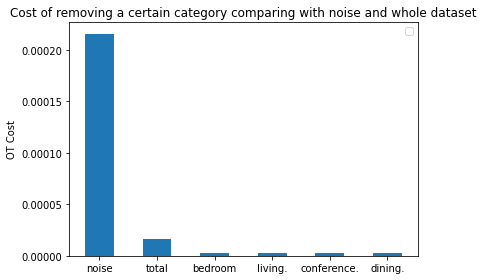

In [11]:
labels = ['noise', 'total', 'bedroom', 'living.', 'conference.', 'dining.']

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, cost, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('OT Cost')
ax.set_title('Cost of removing a certain category comparing with noise and whole dataset')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [39]:
errors_warm = []
reg = 100
unique_labels = torch.unique(real_labels)

_, noise_cost, _, _, _= regularized_sinkhorn_knapp(noise, generated_dist, cost_matrix, reg, check_freq=10000, max_iters=100000)
P, real_cost, u, v, _ = regularized_sinkhorn_knapp(real_features_dist, generated_dist, cost_matrix, reg, check_freq=10000, max_iters=100000)

per_label_cost = {}
for label in unique_labels:
    real_features_wo_one = real_features[real_labels == label]
    real_features_wo_one_dist = mat2prob(real_features_wo_one, 1)
    _, label_cost, _, _ , _= regularized_sinkhorn_knapp(real_features_wo_one_dist, generated_dist, cost_matrix, reg, initial_u=u, initial_v=v, check_freq=10, max_iters=10000)
    errors_warm.append(error)
    per_label_cost[label.item()] = label_cost.item()



C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(c, dtype=torch.double, device=device)
C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M, dtype=torch.double, device=device)


iters: 0; error : 503.5; elpse per check: 0.01091
iters: 10000; error : 4.887e-06; elpse per check: 0.7187
iters: 20000; error : 9.224e-09; elpse per check: 0.7509
iters: 30000; error : 8.673e-09; elpse per check: 0.7207
iters: 40000; error : 8.673e-09; elpse per check: 0.7297
iters: 50000; error : 8.673e-09; elpse per check: 0.7425
iters: 60000; error : 8.673e-09; elpse per check: 0.739
iters: 70000; error : 8.673e-09; elpse per check: 0.7108
iters: 80000; error : 8.673e-09; elpse per check: 0.6924
iters: 90000; error : 8.673e-09; elpse per check: 0.6993
total time: 7.2093589305877686
iters: 0; error : 538.5; elpse per check: 0.02036


C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r, dtype=torch.double, device=device)


iters: 10000; error : 0.0004041; elpse per check: 0.7286
iters: 20000; error : 7.234e-05; elpse per check: 0.7068
iters: 30000; error : 4.088e-05; elpse per check: 0.7192
iters: 40000; error : 2.893e-05; elpse per check: 0.7038
iters: 50000; error : 1.433e-05; elpse per check: 0.7321
iters: 60000; error : 1.217e-05; elpse per check: 0.7172
iters: 70000; error : 1.054e-05; elpse per check: 0.6969
iters: 80000; error : 6.281e-06; elpse per check: 0.7137
iters: 90000; error : 5.245e-06; elpse per check: 0.7118
total time: 7.168217658996582
iters: 0; error : 0.002072; elpse per check: 0.01227
iters: 10; error : 0.001804; elpse per check: 0.0114
iters: 20; error : 0.001616; elpse per check: 0.01141
iters: 30; error : 0.001486; elpse per check: 0.01089
iters: 40; error : 0.001389; elpse per check: 0.01094
iters: 50; error : 0.00131; elpse per check: 0.01091
iters: 60; error : 0.001243; elpse per check: 0.01141
iters: 70; error : 0.001184; elpse per check: 0.01141
iters: 80; error : 0.001133;

iters: 1520; error : 0.0001852; elpse per check: 0.01141
iters: 1530; error : 0.000184; elpse per check: 0.01091
iters: 1540; error : 0.0001829; elpse per check: 0.01091
iters: 1550; error : 0.0001818; elpse per check: 0.01045
iters: 1560; error : 0.0001806; elpse per check: 0.01039
iters: 1570; error : 0.0001795; elpse per check: 0.01091
iters: 1580; error : 0.0001785; elpse per check: 0.00992
iters: 1590; error : 0.0001774; elpse per check: 0.01141
iters: 1600; error : 0.0001763; elpse per check: 0.01091
iters: 1610; error : 0.0001753; elpse per check: 0.01041
iters: 1620; error : 0.0001743; elpse per check: 0.01042
iters: 1630; error : 0.0001732; elpse per check: 0.01141
iters: 1640; error : 0.0001722; elpse per check: 0.01091
iters: 1650; error : 0.0001712; elpse per check: 0.01042
iters: 1660; error : 0.0001702; elpse per check: 0.01141
iters: 1670; error : 0.0001693; elpse per check: 0.01091
iters: 1680; error : 0.0001683; elpse per check: 0.009919
iters: 1690; error : 0.0001673;

iters: 3010; error : 9.154e-05; elpse per check: 0.01091
iters: 3020; error : 9.119e-05; elpse per check: 0.01091
iters: 3030; error : 9.084e-05; elpse per check: 0.00992
iters: 3040; error : 9.049e-05; elpse per check: 0.01042
iters: 3050; error : 9.015e-05; elpse per check: 0.01091
iters: 3060; error : 8.981e-05; elpse per check: 0.00992
iters: 3070; error : 8.946e-05; elpse per check: 0.00992
iters: 3080; error : 8.913e-05; elpse per check: 0.01091
iters: 3090; error : 8.879e-05; elpse per check: 0.00992
iters: 3100; error : 8.846e-05; elpse per check: 0.00992
iters: 3110; error : 8.812e-05; elpse per check: 0.01091
iters: 3120; error : 8.779e-05; elpse per check: 0.01091
iters: 3130; error : 8.747e-05; elpse per check: 0.00992
iters: 3140; error : 8.714e-05; elpse per check: 0.01091
iters: 3150; error : 8.682e-05; elpse per check: 0.00992
iters: 3160; error : 8.65e-05; elpse per check: 0.0129
iters: 3170; error : 8.618e-05; elpse per check: 0.01091
iters: 3180; error : 8.586e-05; e

iters: 4480; error : 5.919e-05; elpse per check: 0.01091
iters: 4490; error : 5.907e-05; elpse per check: 0.01091
iters: 4500; error : 5.895e-05; elpse per check: 0.01091
iters: 4510; error : 5.884e-05; elpse per check: 0.01091
iters: 4520; error : 5.872e-05; elpse per check: 0.01091
iters: 4530; error : 5.861e-05; elpse per check: 0.01042
iters: 4540; error : 5.85e-05; elpse per check: 0.0124
iters: 4550; error : 5.839e-05; elpse per check: 0.01091
iters: 4560; error : 5.828e-05; elpse per check: 0.01042
iters: 4570; error : 5.817e-05; elpse per check: 0.01091
iters: 4580; error : 5.806e-05; elpse per check: 0.0119
iters: 4590; error : 5.795e-05; elpse per check: 0.009921
iters: 4600; error : 5.784e-05; elpse per check: 0.0119
iters: 4610; error : 5.774e-05; elpse per check: 0.01042
iters: 4620; error : 5.763e-05; elpse per check: 0.00992
iters: 4630; error : 5.753e-05; elpse per check: 0.01141
iters: 4640; error : 5.742e-05; elpse per check: 0.01091
iters: 4650; error : 5.732e-05; el

iters: 5970; error : 4.895e-05; elpse per check: 0.01143
iters: 5980; error : 4.891e-05; elpse per check: 0.01041
iters: 5990; error : 4.887e-05; elpse per check: 0.009897
iters: 6000; error : 4.884e-05; elpse per check: 0.01091
iters: 6010; error : 4.88e-05; elpse per check: 0.01045
iters: 6020; error : 4.876e-05; elpse per check: 0.009889
iters: 6030; error : 4.873e-05; elpse per check: 0.01044
iters: 6040; error : 4.869e-05; elpse per check: 0.01138
iters: 6050; error : 4.866e-05; elpse per check: 0.009425
iters: 6060; error : 4.862e-05; elpse per check: 0.009943
iters: 6070; error : 4.858e-05; elpse per check: 0.01039
iters: 6080; error : 4.855e-05; elpse per check: 0.009449
iters: 6090; error : 4.851e-05; elpse per check: 0.01091
iters: 6100; error : 4.848e-05; elpse per check: 0.01039
iters: 6110; error : 4.845e-05; elpse per check: 0.00945
iters: 6120; error : 4.841e-05; elpse per check: 0.009919
iters: 6130; error : 4.838e-05; elpse per check: 0.01089
iters: 6140; error : 4.834

iters: 7450; error : 4.528e-05; elpse per check: 0.0124
iters: 7460; error : 4.526e-05; elpse per check: 0.01091
iters: 7470; error : 4.524e-05; elpse per check: 0.01042
iters: 7480; error : 4.523e-05; elpse per check: 0.01091
iters: 7490; error : 4.521e-05; elpse per check: 0.01042
iters: 7500; error : 4.52e-05; elpse per check: 0.01042
iters: 7510; error : 4.518e-05; elpse per check: 0.01091
iters: 7520; error : 4.517e-05; elpse per check: 0.01091
iters: 7530; error : 4.515e-05; elpse per check: 0.01042
iters: 7540; error : 4.513e-05; elpse per check: 0.01141
iters: 7550; error : 4.512e-05; elpse per check: 0.01091
iters: 7560; error : 4.51e-05; elpse per check: 0.00992
iters: 7570; error : 4.509e-05; elpse per check: 0.009943
iters: 7580; error : 4.507e-05; elpse per check: 0.01092
iters: 7590; error : 4.506e-05; elpse per check: 0.009889
iters: 7600; error : 4.504e-05; elpse per check: 0.009921
iters: 7610; error : 4.503e-05; elpse per check: 0.01093
iters: 7620; error : 4.501e-05;

iters: 8970; error : 4.35e-05; elpse per check: 0.01089
iters: 8980; error : 4.349e-05; elpse per check: 0.01193
iters: 8990; error : 4.348e-05; elpse per check: 0.01039
iters: 9000; error : 4.347e-05; elpse per check: 0.01042
iters: 9010; error : 4.346e-05; elpse per check: 0.01091
iters: 9020; error : 4.346e-05; elpse per check: 0.01042
iters: 9030; error : 4.345e-05; elpse per check: 0.01091
iters: 9040; error : 4.344e-05; elpse per check: 0.01042
iters: 9050; error : 4.343e-05; elpse per check: 0.01091
iters: 9060; error : 4.342e-05; elpse per check: 0.01042
iters: 9070; error : 4.341e-05; elpse per check: 0.01192
iters: 9080; error : 4.34e-05; elpse per check: 0.009905
iters: 9090; error : 4.34e-05; elpse per check: 0.01042
iters: 9100; error : 4.339e-05; elpse per check: 0.01091
iters: 9110; error : 4.338e-05; elpse per check: 0.01141
iters: 9120; error : 4.337e-05; elpse per check: 0.01042
iters: 9130; error : 4.336e-05; elpse per check: 0.01045
iters: 9140; error : 4.336e-05; e

iters: 500; error : 0.0004315; elpse per check: 0.009942
iters: 510; error : 0.0004255; elpse per check: 0.01139
iters: 520; error : 0.0004197; elpse per check: 0.01042
iters: 530; error : 0.000414; elpse per check: 0.009947
iters: 540; error : 0.0004085; elpse per check: 0.01042
iters: 550; error : 0.0004031; elpse per check: 0.009916
iters: 560; error : 0.0003978; elpse per check: 0.009895
iters: 570; error : 0.0003927; elpse per check: 0.01044
iters: 580; error : 0.0003877; elpse per check: 0.01039
iters: 590; error : 0.0003828; elpse per check: 0.01091
iters: 600; error : 0.000378; elpse per check: 0.01091
iters: 610; error : 0.0003733; elpse per check: 0.01141
iters: 620; error : 0.0003688; elpse per check: 0.01091
iters: 630; error : 0.0003643; elpse per check: 0.01091
iters: 640; error : 0.0003599; elpse per check: 0.01042
iters: 650; error : 0.0003557; elpse per check: 0.01091
iters: 660; error : 0.0003515; elpse per check: 0.01091
iters: 670; error : 0.0003474; elpse per check

iters: 2000; error : 0.0001302; elpse per check: 0.01091
iters: 2010; error : 0.0001296; elpse per check: 0.01091
iters: 2020; error : 0.000129; elpse per check: 0.009425
iters: 2030; error : 0.0001283; elpse per check: 0.01042
iters: 2040; error : 0.0001277; elpse per check: 0.01042
iters: 2050; error : 0.0001271; elpse per check: 0.009945
iters: 2060; error : 0.0001266; elpse per check: 0.009398
iters: 2070; error : 0.000126; elpse per check: 0.009949
iters: 2080; error : 0.0001254; elpse per check: 0.01039
iters: 2090; error : 0.0001248; elpse per check: 0.009921
iters: 2100; error : 0.0001242; elpse per check: 0.01045
iters: 2110; error : 0.0001237; elpse per check: 0.01039
iters: 2120; error : 0.0001231; elpse per check: 0.01042
iters: 2130; error : 0.0001226; elpse per check: 0.009944
iters: 2140; error : 0.000122; elpse per check: 0.01089
iters: 2150; error : 0.0001215; elpse per check: 0.009424
iters: 2160; error : 0.0001209; elpse per check: 0.01044
iters: 2170; error : 0.0001

iters: 3520; error : 7.713e-05; elpse per check: 0.00992
iters: 3530; error : 7.695e-05; elpse per check: 0.01091
iters: 3540; error : 7.677e-05; elpse per check: 0.01042
iters: 3550; error : 7.66e-05; elpse per check: 0.00992
iters: 3560; error : 7.642e-05; elpse per check: 0.01042
iters: 3570; error : 7.624e-05; elpse per check: 0.00992
iters: 3580; error : 7.607e-05; elpse per check: 0.01042
iters: 3590; error : 7.589e-05; elpse per check: 0.01141
iters: 3600; error : 7.572e-05; elpse per check: 0.009919
iters: 3610; error : 7.555e-05; elpse per check: 0.009921
iters: 3620; error : 7.538e-05; elpse per check: 0.01092
iters: 3630; error : 7.521e-05; elpse per check: 0.009914
iters: 3640; error : 7.505e-05; elpse per check: 0.00992
iters: 3650; error : 7.488e-05; elpse per check: 0.01091
iters: 3660; error : 7.471e-05; elpse per check: 0.009921
iters: 3670; error : 7.455e-05; elpse per check: 0.01091
iters: 3680; error : 7.439e-05; elpse per check: 0.01042
iters: 3690; error : 7.423e-

iters: 5010; error : 6.036e-05; elpse per check: 0.009897
iters: 5020; error : 6.03e-05; elpse per check: 0.01042
iters: 5030; error : 6.024e-05; elpse per check: 0.01091
iters: 5040; error : 6.017e-05; elpse per check: 0.01091
iters: 5050; error : 6.011e-05; elpse per check: 0.009919
iters: 5060; error : 6.004e-05; elpse per check: 0.009952
iters: 5070; error : 5.998e-05; elpse per check: 0.01041
iters: 5080; error : 5.992e-05; elpse per check: 0.01039
iters: 5090; error : 5.986e-05; elpse per check: 0.01042
iters: 5100; error : 5.98e-05; elpse per check: 0.01094
iters: 5110; error : 5.973e-05; elpse per check: 0.00989
iters: 5120; error : 5.967e-05; elpse per check: 0.00992
iters: 5130; error : 5.961e-05; elpse per check: 0.01044
iters: 5140; error : 5.955e-05; elpse per check: 0.01039
iters: 5150; error : 5.949e-05; elpse per check: 0.01042
iters: 5160; error : 5.943e-05; elpse per check: 0.009948
iters: 5170; error : 5.937e-05; elpse per check: 0.01039
iters: 5180; error : 5.931e-0

iters: 6510; error : 5.382e-05; elpse per check: 0.01091
iters: 6520; error : 5.379e-05; elpse per check: 0.01091
iters: 6530; error : 5.376e-05; elpse per check: 0.01091
iters: 6540; error : 5.373e-05; elpse per check: 0.01042
iters: 6550; error : 5.371e-05; elpse per check: 0.00992
iters: 6560; error : 5.368e-05; elpse per check: 0.01141
iters: 6570; error : 5.365e-05; elpse per check: 0.00992
iters: 6580; error : 5.362e-05; elpse per check: 0.009423
iters: 6590; error : 5.36e-05; elpse per check: 0.01042
iters: 6600; error : 5.357e-05; elpse per check: 0.01042
iters: 6610; error : 5.354e-05; elpse per check: 0.009424
iters: 6620; error : 5.352e-05; elpse per check: 0.01042
iters: 6630; error : 5.349e-05; elpse per check: 0.009919
iters: 6640; error : 5.346e-05; elpse per check: 0.00992
iters: 6650; error : 5.344e-05; elpse per check: 0.01042
iters: 6660; error : 5.341e-05; elpse per check: 0.01042
iters: 6670; error : 5.338e-05; elpse per check: 0.00992
iters: 6680; error : 5.336e-0

iters: 8010; error : 5.1e-05; elpse per check: 0.01141
iters: 8020; error : 5.099e-05; elpse per check: 0.01042
iters: 8030; error : 5.097e-05; elpse per check: 0.01091
iters: 8040; error : 5.096e-05; elpse per check: 0.01042
iters: 8050; error : 5.095e-05; elpse per check: 0.01042
iters: 8060; error : 5.094e-05; elpse per check: 0.01042
iters: 8070; error : 5.093e-05; elpse per check: 0.00992
iters: 8080; error : 5.092e-05; elpse per check: 0.01042
iters: 8090; error : 5.09e-05; elpse per check: 0.01042
iters: 8100; error : 5.089e-05; elpse per check: 0.01091
iters: 8110; error : 5.088e-05; elpse per check: 0.01091
iters: 8120; error : 5.087e-05; elpse per check: 0.00992
iters: 8130; error : 5.086e-05; elpse per check: 0.01042
iters: 8140; error : 5.085e-05; elpse per check: 0.01042
iters: 8150; error : 5.084e-05; elpse per check: 0.01042
iters: 8160; error : 5.083e-05; elpse per check: 0.01042
iters: 8170; error : 5.081e-05; elpse per check: 0.01091
iters: 8180; error : 5.08e-05; elp

iters: 9520; error : 4.967e-05; elpse per check: 0.01042
iters: 9530; error : 4.967e-05; elpse per check: 0.01091
iters: 9540; error : 4.966e-05; elpse per check: 0.01042
iters: 9550; error : 4.965e-05; elpse per check: 0.009423
iters: 9560; error : 4.964e-05; elpse per check: 0.01141
iters: 9570; error : 4.964e-05; elpse per check: 0.01091
iters: 9580; error : 4.963e-05; elpse per check: 0.00992
iters: 9590; error : 4.962e-05; elpse per check: 0.00992
iters: 9600; error : 4.962e-05; elpse per check: 0.01042
iters: 9610; error : 4.961e-05; elpse per check: 0.01042
iters: 9620; error : 4.96e-05; elpse per check: 0.01091
iters: 9630; error : 4.96e-05; elpse per check: 0.01042
iters: 9640; error : 4.959e-05; elpse per check: 0.00992
iters: 9650; error : 4.958e-05; elpse per check: 0.00992
iters: 9660; error : 4.958e-05; elpse per check: 0.00992
iters: 9670; error : 4.957e-05; elpse per check: 0.01042
iters: 9680; error : 4.956e-05; elpse per check: 0.009921
iters: 9690; error : 4.956e-05;

iters: 1050; error : 0.0005513; elpse per check: 0.01042
iters: 1060; error : 0.0005474; elpse per check: 0.01141
iters: 1070; error : 0.0005437; elpse per check: 0.01141
iters: 1080; error : 0.0005399; elpse per check: 0.01042
iters: 1090; error : 0.0005363; elpse per check: 0.009921
iters: 1100; error : 0.0005326; elpse per check: 0.01041
iters: 1110; error : 0.000529; elpse per check: 0.01042
iters: 1120; error : 0.0005255; elpse per check: 0.01042
iters: 1130; error : 0.000522; elpse per check: 0.00992
iters: 1140; error : 0.0005186; elpse per check: 0.01042
iters: 1150; error : 0.0005152; elpse per check: 0.01042
iters: 1160; error : 0.0005118; elpse per check: 0.01042
iters: 1170; error : 0.0005085; elpse per check: 0.01042
iters: 1180; error : 0.0005052; elpse per check: 0.00992
iters: 1190; error : 0.000502; elpse per check: 0.01042
iters: 1200; error : 0.0004987; elpse per check: 0.01042
iters: 1210; error : 0.0004956; elpse per check: 0.01042
iters: 1220; error : 0.0004924; e

iters: 2530; error : 0.0002392; elpse per check: 0.01042
iters: 2540; error : 0.0002381; elpse per check: 0.00992
iters: 2550; error : 0.0002369; elpse per check: 0.01141
iters: 2560; error : 0.0002358; elpse per check: 0.01091
iters: 2570; error : 0.0002348; elpse per check: 0.00992
iters: 2580; error : 0.0002337; elpse per check: 0.01091
iters: 2590; error : 0.0002326; elpse per check: 0.01141
iters: 2600; error : 0.0002315; elpse per check: 0.01042
iters: 2610; error : 0.0002305; elpse per check: 0.01141
iters: 2620; error : 0.0002294; elpse per check: 0.00992
iters: 2630; error : 0.0002284; elpse per check: 0.01091
iters: 2640; error : 0.0002274; elpse per check: 0.01091
iters: 2650; error : 0.0002263; elpse per check: 0.01091
iters: 2660; error : 0.0002253; elpse per check: 0.00992
iters: 2670; error : 0.0002243; elpse per check: 0.01003
iters: 2680; error : 0.0002233; elpse per check: 0.01039
iters: 2690; error : 0.0002224; elpse per check: 0.01044
iters: 2700; error : 0.0002214;

iters: 4020; error : 0.0001367; elpse per check: 0.01141
iters: 4030; error : 0.0001363; elpse per check: 0.01042
iters: 4040; error : 0.0001359; elpse per check: 0.01042
iters: 4050; error : 0.0001355; elpse per check: 0.01141
iters: 4060; error : 0.0001351; elpse per check: 0.00992
iters: 4070; error : 0.0001347; elpse per check: 0.01042
iters: 4080; error : 0.0001343; elpse per check: 0.01141
iters: 4090; error : 0.0001339; elpse per check: 0.009919
iters: 4100; error : 0.0001336; elpse per check: 0.00992
iters: 4110; error : 0.0001332; elpse per check: 0.01091
iters: 4120; error : 0.0001328; elpse per check: 0.00992
iters: 4130; error : 0.0001324; elpse per check: 0.01042
iters: 4140; error : 0.000132; elpse per check: 0.01042
iters: 4150; error : 0.0001317; elpse per check: 0.00992
iters: 4160; error : 0.0001313; elpse per check: 0.01042
iters: 4170; error : 0.0001309; elpse per check: 0.01091
iters: 4180; error : 0.0001305; elpse per check: 0.009919
iters: 4190; error : 0.0001302

iters: 5550; error : 0.0001008; elpse per check: 0.01141
iters: 5560; error : 0.0001007; elpse per check: 0.01042
iters: 5570; error : 0.0001006; elpse per check: 0.009919
iters: 5580; error : 0.0001004; elpse per check: 0.009921
iters: 5590; error : 0.0001003; elpse per check: 0.01042
iters: 5600; error : 0.0001002; elpse per check: 0.01042
iters: 5610; error : 0.0001001; elpse per check: 0.01042
iters: 5620; error : 0.0001; elpse per check: 0.01091
iters: 5630; error : 9.991e-05; elpse per check: 0.01141
iters: 5640; error : 9.981e-05; elpse per check: 0.0119
iters: 5650; error : 9.97e-05; elpse per check: 0.01042
iters: 5660; error : 9.96e-05; elpse per check: 0.0119
iters: 5670; error : 9.95e-05; elpse per check: 0.01091
iters: 5680; error : 9.94e-05; elpse per check: 0.01091
iters: 5690; error : 9.93e-05; elpse per check: 0.0119
iters: 5700; error : 9.92e-05; elpse per check: 0.01042
iters: 5710; error : 9.91e-05; elpse per check: 0.00992
iters: 5720; error : 9.9e-05; elpse per ch

iters: 7000; error : 9.132e-05; elpse per check: 0.01091
iters: 7010; error : 9.129e-05; elpse per check: 0.01042
iters: 7020; error : 9.126e-05; elpse per check: 0.01042
iters: 7030; error : 9.123e-05; elpse per check: 0.01042
iters: 7040; error : 9.119e-05; elpse per check: 0.01042
iters: 7050; error : 9.116e-05; elpse per check: 0.01042
iters: 7060; error : 9.113e-05; elpse per check: 0.01042
iters: 7070; error : 9.11e-05; elpse per check: 0.01042
iters: 7080; error : 9.107e-05; elpse per check: 0.01091
iters: 7090; error : 9.104e-05; elpse per check: 0.01141
iters: 7100; error : 9.101e-05; elpse per check: 0.00992
iters: 7110; error : 9.098e-05; elpse per check: 0.01091
iters: 7120; error : 9.095e-05; elpse per check: 0.01042
iters: 7130; error : 9.092e-05; elpse per check: 0.01042
iters: 7140; error : 9.089e-05; elpse per check: 0.01042
iters: 7150; error : 9.086e-05; elpse per check: 0.009919
iters: 7160; error : 9.083e-05; elpse per check: 0.01042
iters: 7170; error : 9.081e-05;

iters: 8480; error : 8.844e-05; elpse per check: 0.00992
iters: 8490; error : 8.843e-05; elpse per check: 0.01042
iters: 8500; error : 8.842e-05; elpse per check: 0.01091
iters: 8510; error : 8.841e-05; elpse per check: 0.00992
iters: 8520; error : 8.84e-05; elpse per check: 0.00992
iters: 8530; error : 8.839e-05; elpse per check: 0.01091
iters: 8540; error : 8.837e-05; elpse per check: 0.00992
iters: 8550; error : 8.836e-05; elpse per check: 0.00992
iters: 8560; error : 8.835e-05; elpse per check: 0.01042
iters: 8570; error : 8.834e-05; elpse per check: 0.00992
iters: 8580; error : 8.833e-05; elpse per check: 0.009919
iters: 8590; error : 8.832e-05; elpse per check: 0.01144
iters: 8600; error : 8.831e-05; elpse per check: 0.009423
iters: 8610; error : 8.83e-05; elpse per check: 0.009892
iters: 8620; error : 8.829e-05; elpse per check: 0.01094
iters: 8630; error : 8.828e-05; elpse per check: 0.009891
iters: 8640; error : 8.827e-05; elpse per check: 0.00995
iters: 8650; error : 8.826e-0

iters: 9980; error : 8.734e-05; elpse per check: 0.01091
iters: 9990; error : 8.733e-05; elpse per check: 0.01091
total time: 10.44228482246399
iters: 0; error : 0.002647; elpse per check: 0.01042
iters: 10; error : 0.002345; elpse per check: 0.01042
iters: 20; error : 0.002127; elpse per check: 0.01042
iters: 30; error : 0.001973; elpse per check: 0.00992
iters: 40; error : 0.001852; elpse per check: 0.01042
iters: 50; error : 0.001751; elpse per check: 0.01042
iters: 60; error : 0.001667; elpse per check: 0.00992
iters: 70; error : 0.001594; elpse per check: 0.01042
iters: 80; error : 0.00153; elpse per check: 0.01042
iters: 90; error : 0.001473; elpse per check: 0.01042
iters: 100; error : 0.001422; elpse per check: 0.01042
iters: 110; error : 0.001375; elpse per check: 0.00992
iters: 120; error : 0.001332; elpse per check: 0.01042
iters: 130; error : 0.001292; elpse per check: 0.01042
iters: 140; error : 0.001255; elpse per check: 0.01042
iters: 150; error : 0.001221; elpse per che

iters: 1450; error : 0.0003083; elpse per check: 0.01042
iters: 1460; error : 0.0003064; elpse per check: 0.01205
iters: 1470; error : 0.0003045; elpse per check: 0.009951
iters: 1480; error : 0.0003026; elpse per check: 0.01038
iters: 1490; error : 0.0003008; elpse per check: 0.01044
iters: 1500; error : 0.000299; elpse per check: 0.01039
iters: 1510; error : 0.0002971; elpse per check: 0.009921
iters: 1520; error : 0.0002954; elpse per check: 0.01042
iters: 1530; error : 0.0002936; elpse per check: 0.01091
iters: 1540; error : 0.0002918; elpse per check: 0.009948
iters: 1550; error : 0.0002901; elpse per check: 0.01042
iters: 1560; error : 0.0002884; elpse per check: 0.01042
iters: 1570; error : 0.0002867; elpse per check: 0.009917
iters: 1580; error : 0.000285; elpse per check: 0.01088
iters: 1590; error : 0.0002834; elpse per check: 0.01042
iters: 1600; error : 0.0002818; elpse per check: 0.009938
iters: 1610; error : 0.0002801; elpse per check: 0.01139
iters: 1620; error : 0.00027

iters: 2890; error : 0.0001655; elpse per check: 0.01141
iters: 2900; error : 0.000165; elpse per check: 0.01092
iters: 2910; error : 0.0001645; elpse per check: 0.0109
iters: 2920; error : 0.0001641; elpse per check: 0.01039
iters: 2930; error : 0.0001636; elpse per check: 0.009448
iters: 2940; error : 0.0001632; elpse per check: 0.01138
iters: 2950; error : 0.0001627; elpse per check: 0.01042
iters: 2960; error : 0.0001623; elpse per check: 0.009919
iters: 2970; error : 0.0001618; elpse per check: 0.01042
iters: 2980; error : 0.0001614; elpse per check: 0.01042
iters: 2990; error : 0.000161; elpse per check: 0.00992
iters: 3000; error : 0.0001605; elpse per check: 0.009944
iters: 3010; error : 0.0001601; elpse per check: 0.01042
iters: 3020; error : 0.0001597; elpse per check: 0.009895
iters: 3030; error : 0.0001593; elpse per check: 0.01092
iters: 3040; error : 0.0001589; elpse per check: 0.01043
iters: 3050; error : 0.0001585; elpse per check: 0.0094
iters: 3060; error : 0.000158; 

iters: 4340; error : 0.0001249; elpse per check: 0.01094
iters: 4350; error : 0.0001247; elpse per check: 0.01188
iters: 4360; error : 0.0001246; elpse per check: 0.009449
iters: 4370; error : 0.0001244; elpse per check: 0.01138
iters: 4380; error : 0.0001243; elpse per check: 0.009448
iters: 4390; error : 0.0001241; elpse per check: 0.009921
iters: 4400; error : 0.000124; elpse per check: 0.01039
iters: 4410; error : 0.0001238; elpse per check: 0.01042
iters: 4420; error : 0.0001237; elpse per check: 0.009944
iters: 4430; error : 0.0001235; elpse per check: 0.01089
iters: 4440; error : 0.0001234; elpse per check: 0.01044
iters: 4450; error : 0.0001232; elpse per check: 0.009891
iters: 4460; error : 0.0001231; elpse per check: 0.009921
iters: 4470; error : 0.0001229; elpse per check: 0.01143
iters: 4480; error : 0.0001228; elpse per check: 0.009928
iters: 4490; error : 0.0001226; elpse per check: 0.01038
iters: 4500; error : 0.0001225; elpse per check: 0.01045
iters: 4510; error : 0.00

iters: 5820; error : 0.0001095; elpse per check: 0.0119
iters: 5830; error : 0.0001094; elpse per check: 0.01091
iters: 5840; error : 0.0001093; elpse per check: 0.01042
iters: 5850; error : 0.0001093; elpse per check: 0.00992
iters: 5860; error : 0.0001092; elpse per check: 0.00992
iters: 5870; error : 0.0001091; elpse per check: 0.01042
iters: 5880; error : 0.0001091; elpse per check: 0.01091
iters: 5890; error : 0.000109; elpse per check: 0.009921
iters: 5900; error : 0.0001089; elpse per check: 0.01042
iters: 5910; error : 0.0001089; elpse per check: 0.00992
iters: 5920; error : 0.0001088; elpse per check: 0.01042
iters: 5930; error : 0.0001087; elpse per check: 0.01042
iters: 5940; error : 0.0001086; elpse per check: 0.01091
iters: 5950; error : 0.0001086; elpse per check: 0.00992
iters: 5960; error : 0.0001085; elpse per check: 0.01042
iters: 5970; error : 0.0001084; elpse per check: 0.00992
iters: 5980; error : 0.0001084; elpse per check: 0.01042
iters: 5990; error : 0.0001083; 

iters: 7310; error : 9.993e-05; elpse per check: 0.01091
iters: 7320; error : 9.985e-05; elpse per check: 0.01091
iters: 7330; error : 9.978e-05; elpse per check: 0.01042
iters: 7340; error : 9.97e-05; elpse per check: 0.01042
iters: 7350; error : 9.962e-05; elpse per check: 0.00992
iters: 7360; error : 9.955e-05; elpse per check: 0.00992
iters: 7370; error : 9.947e-05; elpse per check: 0.009919
iters: 7380; error : 9.939e-05; elpse per check: 0.01091
iters: 7390; error : 9.932e-05; elpse per check: 0.00992
iters: 7400; error : 9.924e-05; elpse per check: 0.01042
iters: 7410; error : 9.916e-05; elpse per check: 0.01042
iters: 7420; error : 9.908e-05; elpse per check: 0.009919
iters: 7430; error : 9.9e-05; elpse per check: 0.00992
iters: 7440; error : 9.892e-05; elpse per check: 0.01141
iters: 7450; error : 9.884e-05; elpse per check: 0.00992
iters: 7460; error : 9.876e-05; elpse per check: 0.00992
iters: 7470; error : 9.868e-05; elpse per check: 0.01042
iters: 7480; error : 9.86e-05; e

iters: 8820; error : 8.424e-05; elpse per check: 0.0119
iters: 8830; error : 8.411e-05; elpse per check: 0.009921
iters: 8840; error : 8.399e-05; elpse per check: 0.01138
iters: 8850; error : 8.386e-05; elpse per check: 0.00992
iters: 8860; error : 8.374e-05; elpse per check: 0.009449
iters: 8870; error : 8.361e-05; elpse per check: 0.01039
iters: 8880; error : 8.348e-05; elpse per check: 0.01042
iters: 8890; error : 8.336e-05; elpse per check: 0.00992
iters: 8900; error : 8.323e-05; elpse per check: 0.009952
iters: 8910; error : 8.311e-05; elpse per check: 0.009888
iters: 8920; error : 8.298e-05; elpse per check: 0.01045
iters: 8930; error : 8.286e-05; elpse per check: 0.01039
iters: 8940; error : 8.273e-05; elpse per check: 0.01042
iters: 8950; error : 8.26e-05; elpse per check: 0.009942
iters: 8960; error : 8.248e-05; elpse per check: 0.009898
iters: 8970; error : 8.235e-05; elpse per check: 0.01042
iters: 8980; error : 8.222e-05; elpse per check: 0.00992
iters: 8990; error : 8.21e-

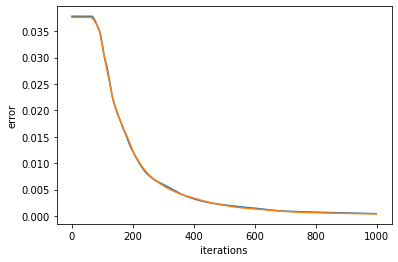

In [49]:
plt.plot(errors[0][1:])
plt.plot(errors_warm[0][1:])
plt.xlabel("iterations")
plt.ylabel("error")
plt.show()

In [55]:
reg = 100
unique_labels = torch.unique(real_labels)

_, noise_cost, _, _, _ = regularized_sinkhorn_knapp(noise, ob_dist, cost_matrix, reg, check_freq=10000, max_iters=100000)
P, real_cost, u, v, _ = regularized_sinkhorn_knapp(real_features_dist, ob_dist, cost_matrix, reg, check_freq=10000, max_iters=100000)

per_label_cost = {}
errors = []
for label in unique_labels:
    real_features_wo_one = real_features[real_labels == label]
    real_features_wo_one_dist = mat2prob(real_features_wo_one, 1)
    _, label_cost, _, _, error = regularized_sinkhorn_knapp(real_features_wo_one_dist, ob_dist, cost_matrix, reg, check_freq=10000, max_iters=100000)
    errors.append(error)
    per_label_cost[label.item()] = label_cost.item()

C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(c, dtype=torch.double, device=device)
C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M, dtype=torch.double, device=device)


iters: 0; error : 482.3; elpse per check: 0.01091
iters: 10000; error : 6.265e-05; elpse per check: 0.7202
iters: 20000; error : 5.236e-06; elpse per check: 0.6904
iters: 30000; error : 4.803e-06; elpse per check: 0.7088
iters: 40000; error : 1.31e-06; elpse per check: 0.7147
iters: 50000; error : 4.962e-07; elpse per check: 0.6999
iters: 60000; error : 2.483e-08; elpse per check: 0.7068
iters: 70000; error : 2.48e-08; elpse per check: 0.6928
iters: 80000; error : 2.48e-08; elpse per check: 0.6944
iters: 90000; error : 2.48e-08; elpse per check: 0.7107
total time: 7.073771715164185
iters: 0; error : 522.4; elpse per check: 0.02033


C:\Users\zegan\AppData\Local\Temp/ipykernel_21780/1787462962.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r, dtype=torch.double, device=device)


iters: 10000; error : 0.0009566; elpse per check: 0.7118
iters: 20000; error : 0.0002592; elpse per check: 0.7187
iters: 30000; error : 0.0001174; elpse per check: 0.6999
iters: 40000; error : 6.124e-05; elpse per check: 0.7227
iters: 50000; error : 2.982e-05; elpse per check: 0.6969
iters: 60000; error : 2.267e-05; elpse per check: 0.7102
iters: 70000; error : 1.993e-05; elpse per check: 0.7033
iters: 80000; error : 1.419e-05; elpse per check: 0.6989
iters: 90000; error : 1.076e-05; elpse per check: 0.6994
total time: 7.073453187942505
iters: 0; error : 497.2; elpse per check: 0.01286
iters: 10000; error : 0.0009698; elpse per check: 0.7043
iters: 20000; error : 0.0002515; elpse per check: 0.7018
iters: 30000; error : 8.623e-05; elpse per check: 0.7028
iters: 40000; error : 5.023e-05; elpse per check: 0.6924
iters: 50000; error : 3.331e-05; elpse per check: 0.7009
iters: 60000; error : 2.296e-05; elpse per check: 0.6978
iters: 70000; error : 1.335e-05; elpse per check: 0.6999
iters: 8

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


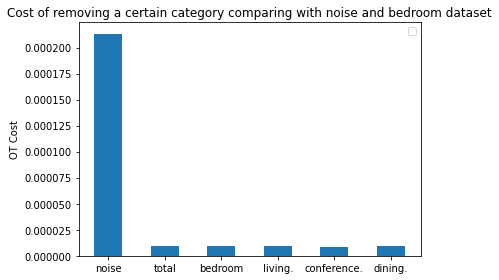

In [57]:
per_label_cost
cost = []
cost.append(noise_cost.item())
cost.append(real_cost.item())
for key in per_label_cost:
    cost.append(per_label_cost[key])
cost

labels = ['noise', 'total', 'bedroom', 'living.', 'conference.', 'dining.']

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, cost, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('OT Cost')
ax.set_title('Cost of removing a certain category comparing with noise and bedroom dataset')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()